In [22]:
import scipy.io as sio 
import numpy as np 

#loading .mat file 

mat = sio.loadmat("BCICIV_calib_ds1a.mat")

cnt = mat['cnt'] # --> continuous EEG 
mrk = mat['mrk'][0,0] #marker struct 
nfo = mat['nfo'][0,0] #info struct 

#EEG is in 10 microvolt --->microvolt

cnt = 0.1 * cnt.astype(np.float32)

# Apply bandpass filter (e.g., 8-30 Hz for motor imagery)
from scipy.signal import butter, lfilter
def bandpass(data, low, high, fs, order=4):
    b, a = butter(order, [low/(fs/2), high/(fs/2)], btype='band')
    return lfilter(b, a, data, axis=0)

cnt = bandpass(cnt, 8, 30, fs)

#extracting sampling rate 

fs = int(nfo['fs'][0,0])

#extracting channels 

channels = [str(ch[0]) for ch in nfo['clab'][0]]


# Extract marker info
positions = mrk['pos'][0]   # sample indices
labels = mrk['y'][0]        # -1 or 1


##
# cnt → (n_samples, n_channels) continuous EEG

#positions → sample indices where cues start

#labels → class labels for each cue

In [23]:

#Usually, we take a time window after each cue (e.g., 0.5–3.5 s after onset).

window = int(3.0 * fs)       # 3s window
offset = int(0.5 * fs)       # 0.5s delay  --> 3+.5=3.5s

X = []
y = []

for pos ,label in zip (positions , labels): 

    start = pos + offset
    end = start + window 

    if end <=cnt.shape[0]:
        epoch = cnt[start:end , :].T # shape (channels, time)  # uses filtered cnt

    X.append(epoch)
    y_value = (0 if label==-1 else 1) 
    y.append(y_value)

X = np.array(X) # shape (n_trials, n_channels, n_times)
y = np.array(y)

print("All epochs:", X.shape, y.shape)

from sklearn.model_selection import train_test_split 

# --- Train/Test split (e.g. 80% train, 20% test) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)



All epochs: (200, 59, 300) (200,)
Train set: (160, 59, 300) (160,)
Test set: (40, 59, 300) (40,)


In [ ]:
# X shape: (n_epochs, n_channels, n_times)
# y shape: (n_epochs,) with labels (-1 or 1)

from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler  # Added for normalization

# Build pipeline: CSP → Normalizer → LDA
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
lda = LDA()
scaler = StandardScaler()  # Standard normalization (zero mean, unit variance)
clf = Pipeline([('CSP', csp), ('Scaler', scaler), ('LDA', lda)])

# Cross-validation on training set
cv = StratifiedKFold(5, shuffle=True, random_state=42)
# Fix for CSP ValueError: ensure input is double precision (float64)
scores = cross_val_score(clf, X_train.astype(np.float64), y_train, cv=cv, n_jobs=1)
print("Mean CV Accuracy: %.2f%%" % (np.mean(scores) * 100))

# Train final model
clf.fit(X_train.astype(np.float64), y_train)
# Apply classifier to held-out test set
y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print("Test Accuracy: %.2f%%" % (test_acc * 100))


predictions = clf.decision_function(X_test)  # real-valued [-1, +1]
np.savetxt("Result_BCIC_IV_ds1.txt", predictions, fmt="%.6f")
print("Saved predictions to Result_BCIC_IV_ds1.txt")

Computing rank from data with rank=None
    Using tolerance 1.4e+02 (2.2e-16 eps * 59 dim * 1.1e+16  max singular value)
    Estimated rank (data): 59
    Using tolerance 1.4e+02 (2.2e-16 eps * 59 dim * 1.1e+16  max singular value)
    Estimated rank (data): 59
    data: rank 59 computed from 59 data channels with 0 projectors
    data: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating class=0 covariance using EMPIRICAL
Done.
Reducing data rank from 59 -> 59
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 1.4e+02 (2.2e-16 eps * 59 dim * 1.1e+16  max singular value)
    Estimated rank (data): 59
    Using tolerance 1.4e+02 (2.2e-16 eps * 59 dim * 1.1e+16  max singular value)
    Estimated rank (data): 59
    data: rank 59 computed f

# Visualization: Raw EEG, Epochs, CSP Patterns, Classifier Results

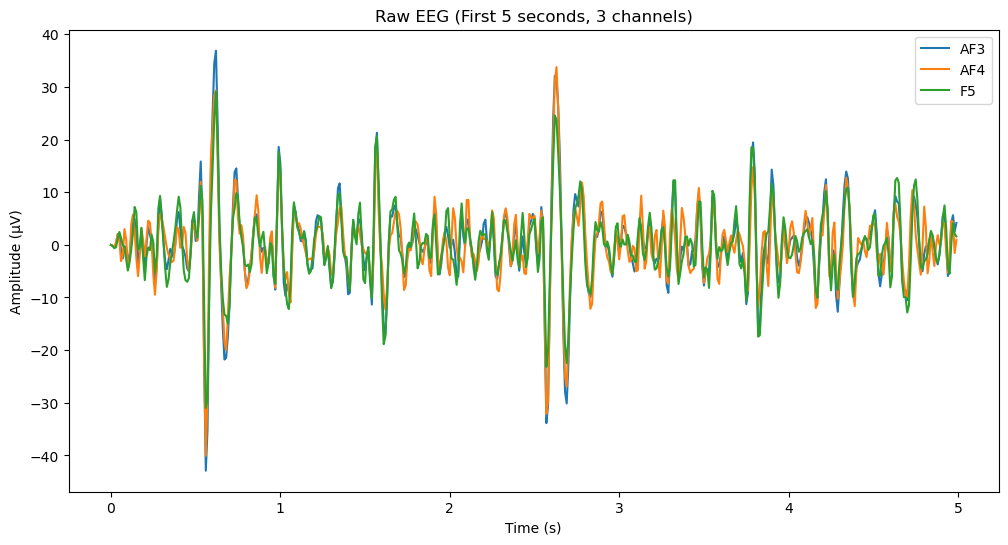

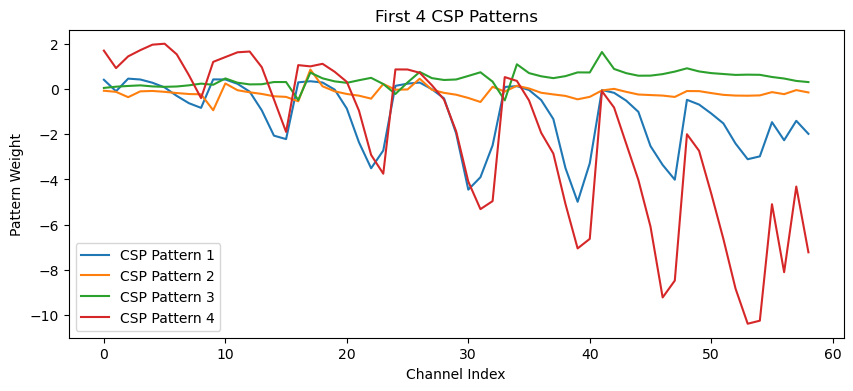

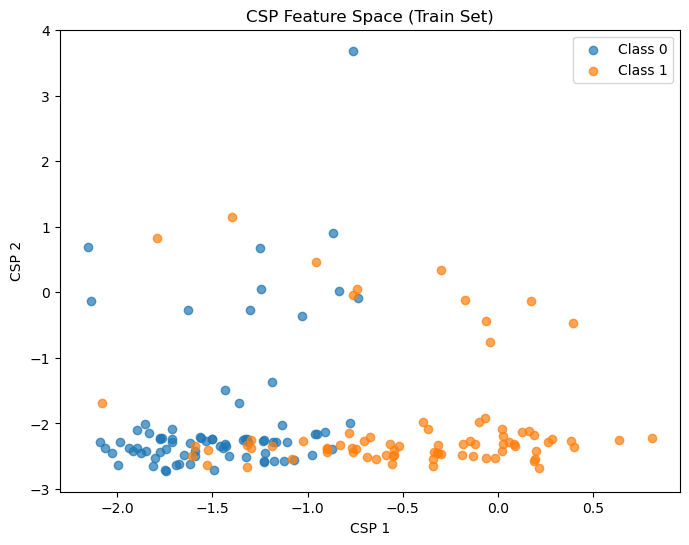

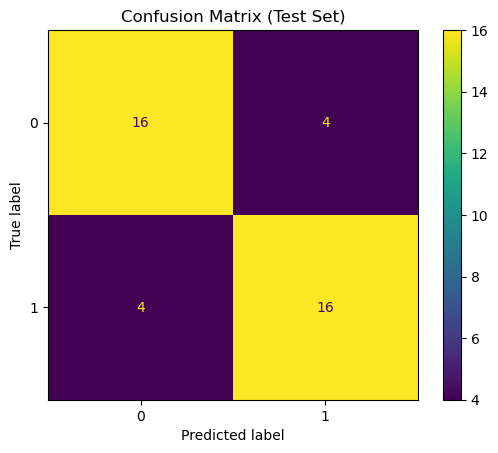

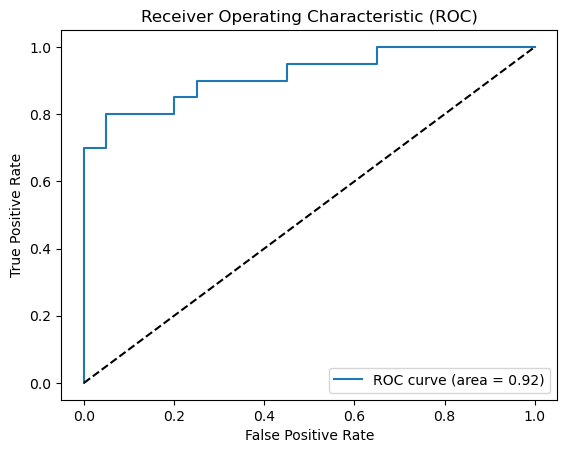

In [25]:
# 1. Plot raw EEG (first 5 seconds, first 3 channels)
import matplotlib.pyplot as plt 

plt.figure(figsize=(12, 6))
time = np.arange(cnt.shape[0]) / fs
for ch in range(3):
    plt.plot(time[:5*fs], cnt[:5*fs, ch], label=channels[ch])
plt.title('Raw EEG (First 5 seconds, 3 channels)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (μV)')
plt.legend()
plt.show()

# 2. Plot a few example epochs 
# 3. Plot CSP patterns (spatial filters)
if 'csp' in locals():
    plt.figure(figsize=(10, 4))
    for i, pattern in enumerate(csp.patterns_[:4]):
        plt.plot(pattern, label=f'CSP Pattern {i+1}')
    plt.title('First 4 CSP Patterns')
    plt.xlabel('Channel Index')
    plt.ylabel('Pattern Weight')
    plt.legend()
    plt.show()
else:
    print('CSP not fitted yet.')

# 4. Visualize classifier decision boundary (2D projection using first 2 CSP features)
if 'clf' in locals() and hasattr(clf.named_steps['CSP'], 'transform'):
    X_csp = clf.named_steps['CSP'].transform(X_train.astype(np.float64))
    plt.figure(figsize=(8, 6))
    for label in np.unique(y_train):
        idx = y_train == label
        plt.scatter(X_csp[idx, 0], X_csp[idx, 1], label=f'Class {label}', alpha=0.7)
    plt.title('CSP Feature Space (Train Set)')
    plt.xlabel('CSP 1')
    plt.ylabel('CSP 2')
    plt.legend()
    plt.show()
else:
    print('Classifier or CSP not fitted yet.')

# 5. Confusion matrix and ROC curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
if 'y_test' in locals() and 'y_pred' in locals():
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion Matrix (Test Set)')
    plt.show()
    # ROC curve (for binary classification)
    if len(np.unique(y_test)) == 2:
        y_score = clf.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc='lower right')
        plt.show()
else:
    print('Test predictions not available.')

Bandpower feature shape: (200, 118)
Mean CV Accuracy (Bandpower+SVM): 78.00%


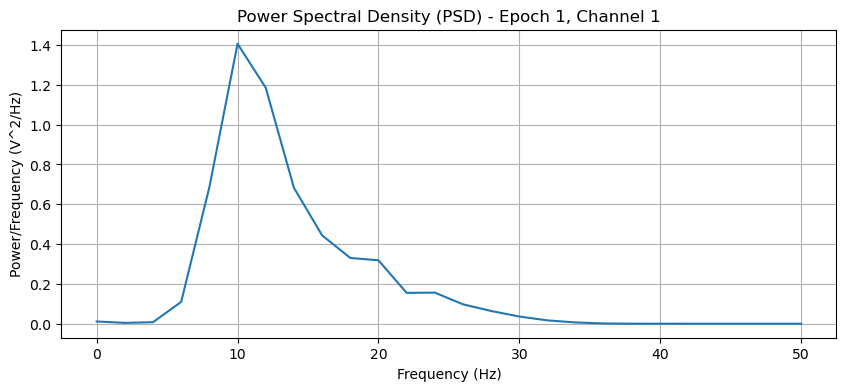

In [30]:
from scipy.signal import welch
import matplotlib.pyplot as plt  # For plotting

def compute_bandpower(epoch, fs, band):
    fmin, fmax = band
    freqs, psd = welch(epoch, fs=fs, nperseg=fs//2)
    idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
    return np.mean(psd[idx_band])

# Compute bandpower features for each epoch and channel (e.g., alpha: 8-12 Hz, beta: 13-30 Hz)
bands = [(8, 12), (13, 30)]
X_bp = []
for epoch in X:
    features = []
    for ch in range(epoch.shape[0]):
        for band in bands:
            features.append(compute_bandpower(epoch[ch], fs, band))
    X_bp.append(features)
X_bp = np.array(X_bp)
print('Bandpower feature shape:', X_bp.shape)

# Example: SVM on bandpower features
scores_bp = cross_val_score(SVC(kernel='rbf'), X_bp, y, cv=cv, n_jobs=1)
print("Mean CV Accuracy (Bandpower+SVM): %.2f%%" % (np.mean(scores_bp) * 100))

# --- Plot frequency domain and PSD for a sample epoch and channel ---
sample_epoch = X[0]  # First epoch
sample_channel = 0   # First channel
signal = sample_epoch[sample_channel]
freqs, psd = welch(signal, fs=fs, nperseg=fs//2)

plt.figure(figsize=(10, 4))
plt.plot(freqs, psd)
plt.title('Power Spectral Density (PSD) - Epoch 1, Channel 1')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (V^2/Hz)')
plt.grid(True)
plt.show()